# Differential Dynamic Microscopy

Here, we go through the steps of performing DDM analysis with the PyDDM package as detailed in our JoVE manuscript. 

## 1. Software installation

We will ned to import [numpy](https://numpy.org/), [matplotlib](https://matplotlib.org/), [xarray](https://xarray.pydata.org/en/stable/), and 
[yaml](https://pyyaml.org/). 
We will also import the [PyDDM](https://rmcgorty.github.io/PyDDM/) package. If a `ModuleNotFoundError` comes up, you may need to install one of these packages.

In [1]:
%matplotlib notebook
from matplotlib import pyplot as plt
import numpy as np
import yaml
import sys
sys.path.append("../PyDDM") #must point to the PyDDM folder
import ddm_analysis_and_fitting as ddm

In [51]:
#Just for formating this notebook, not necessary for the DDM analysis
import IPython.display
from IPython.display import Markdown

<div class="alert alert-block alert-info">
<b>Tip:</b> Use blue boxes (alert-info) for tips and notes. 
If it’s a note, you don’t have to include the word “Note”.
</div>

## 2. Planning the imaging session

### 2.1 Length scales probed

In [55]:
pixel_size = 0.3 #Size of pixel in microns
image_dimension = 256 #Size of image, assumed to be square
numerical_aperture = 0.7 #NA of the imaging objective lens
wavelength_of_light = 0.550 #wavelength of light in microns

wavevector_q = np.arange(0,image_dimension/2)*2*np.pi*(1./(image_dimension*pixel_size))
max_q_based_on_NA = 2*np.pi*numerical_aperture/wavelength_of_light

IPython.display.display(Markdown(rf"Minimum wavevector: ${wavevector_q[1]:.2f} \mu$"r"$m^{-1}$"))
IPython.display.display(Markdown(rf"Maximum wavevector: ${wavevector_q[-1]:.2f} \mu$"r"$m^{-1}$"))
IPython.display.display(Markdown(rf"Maximum wavevector based on optical resolution: ${max_q_based_on_NA:.2f} \mu$"r"$m^{-1}$"))

Minimum wavevector: $0.08 \mu$$m^{-1}$

Maximum wavevector: $10.39 \mu$$m^{-1}$

Maximum wavevector based on optical resolution: $8.00 \mu$$m^{-1}$

The range of accessbible $q$-values is determined by the image dimension and the pixel size. The maximum $q$ may also be limited by the optical resolution of the microscope, which is determined by the numerical aperature of the microscope's imaging lens and the wavelength of light.

### 2.2 Time scales probed

C:\Users\Ryan\Anaconda3\lib\site-packages\ipykernel_launcher.py:9: RuntimeWarning: divide by zero encountered in true_divide
  if __name__ == '__main__':


<IPython.core.display.Javascript object>


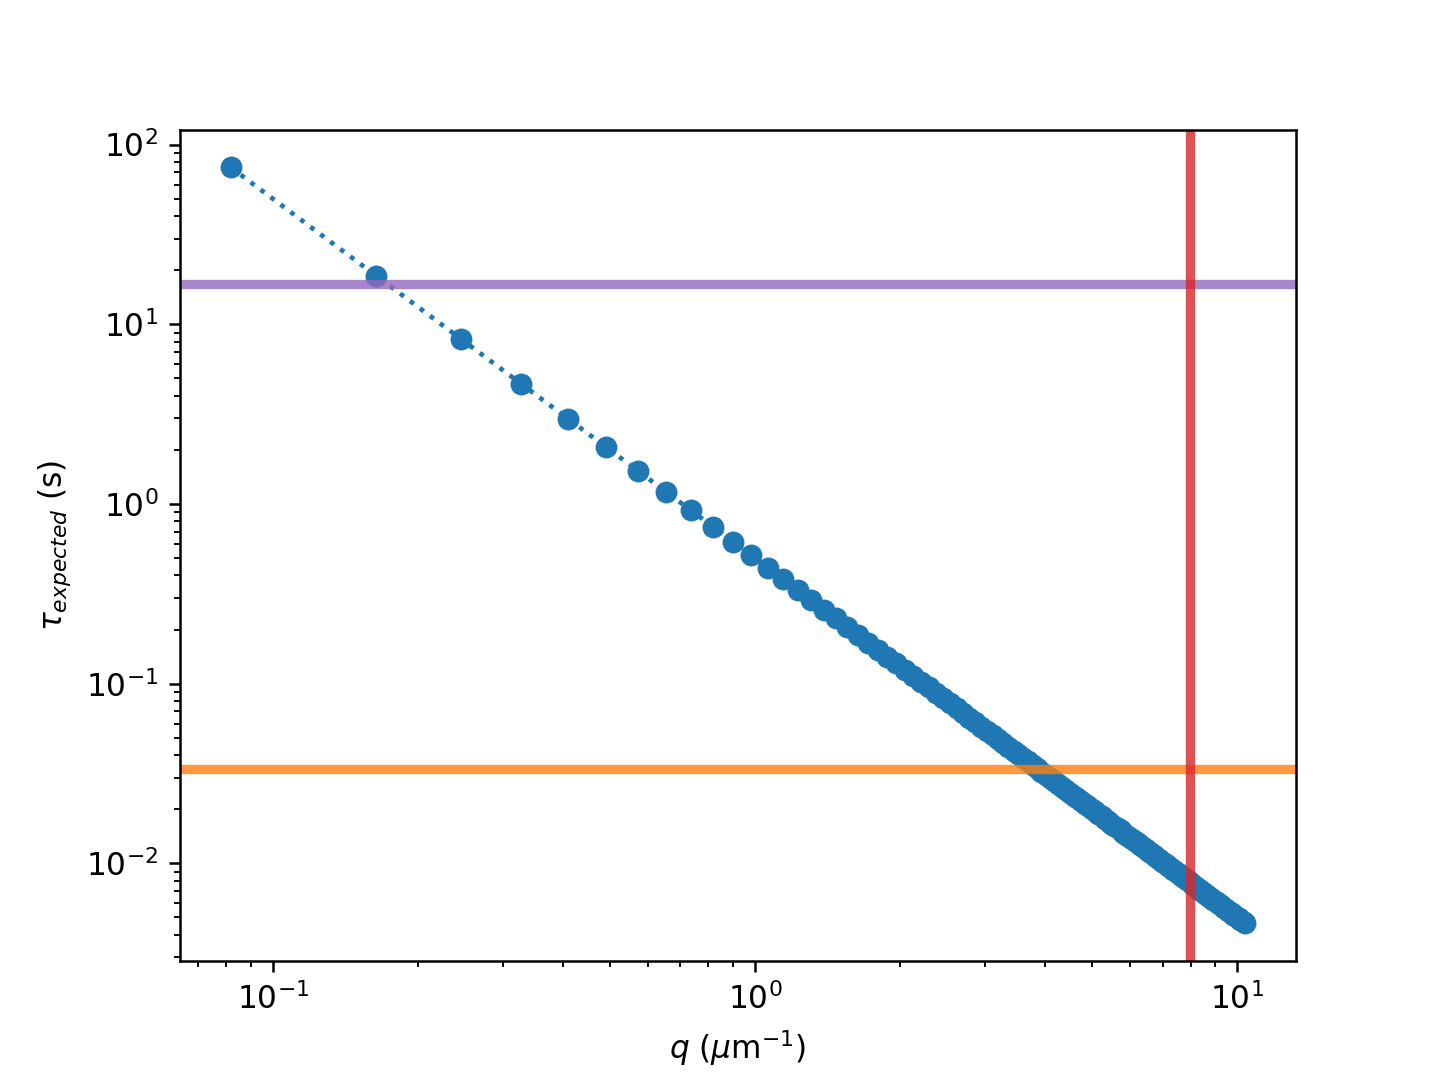

In [22]:
frame_rate = 30 #Frame rate used in imaging experiments
maximum_lag_frame = 500 #Maximum lag time in frames

min_lag_time = 1.0/frame_rate
max_lag_time = maximum_lag_frame / frame_rate

expected_diffusion_coefficient = 2.0 #diffusion coeff in microns squared per second

expected_decay_time = 1.0 / (wavevector_q**2 * expected_diffusion_coefficient)

fig,ax = plt.subplots()
ax.loglog(wavevector_q[1:], expected_decay_time[1:], ':o', color='tab:blue')
ax.set_xlabel("$q$ ($\mu$m$^{-1}$)")
ax.set_ylabel("$\\tau_{expected}$ (s)")
ax.axhline(y = min_lag_time, color='tab:orange', lw=3, alpha=0.8, label="Minimum lag time")
ax.axhline(y = max_lag_time, color='tab:purple', lw=3, alpha=0.8, label='Maximum lag time')
ax.axvline(x = max_q_based_on_NA, color='tab:red', lw=3, alpha=0.8)

## 3. Image acquisition

## 4. Parameter setup

In [36]:
parameters_data_location = """
DataDirectory: './'
FileName: 'images_nobin_40x_128x128_8bit.tif'
"""

For the DDM analysis, we must provide the `DataDirectory` and `FileName` for the data to analyze. Note that the image files may either be in TIFF format or ND2 format. 

### 4.1 Image metadata

In [37]:
parameters_image_metadata = """
Metadata:
  pixel_size: 0.242 # size of pixel in um
  frame_rate: 41.7 #frames per second
"""

Metadata for the recorded images must include `pixel_size` and `frame_rate`. The assume units for these parameters are microns and frames per second, respectively.

### 4.2 Analysis parameters

In [38]:
parameters_analysis = """
Analysis_parameters:
  number_lag_times: 40
  last_lag_time: 600
"""

### 4.3 Fitting parameters

In [39]:
parameters_fitting = """
Fitting_parameters:
  model: 'DDM Matrix - Single Exponential' 
  Tau: [1.0, 0.001, 10]
  StretchingExp: [1.0, 0.5, 1.1]
  Amplitude: [1e2, 1, 1e6]
  Background: [2.5e4, 0, 1e7]
"""

## 5. Calculating the DDM matrix

In [40]:
ddm_analysis_parameters_str = parameters_data_location + parameters_image_metadata + \
                              parameters_analysis + parameters_fitting
parameters_as_dictionary = yaml.safe_load(ddm_analysis_parameters_str)

ddm_calc = ddm.DDM_Analysis(parameters_as_dictionary)

Provided metadata: {'pixel_size': 0.242, 'frame_rate': 41.7}
Image shape: 3000-by-128-by-128
Number of frames to use for analysis: 3000
Maximum lag time (in frames): 600
Number of lag times to compute DDM matrix: 40
Using the full frame, dimensions: 128-by-128.


DDM matrix took 41.573091983795166 seconds to compute.
 Background estimate ± std is 211.17 ± 1.49


<IPython.core.display.Javascript object>


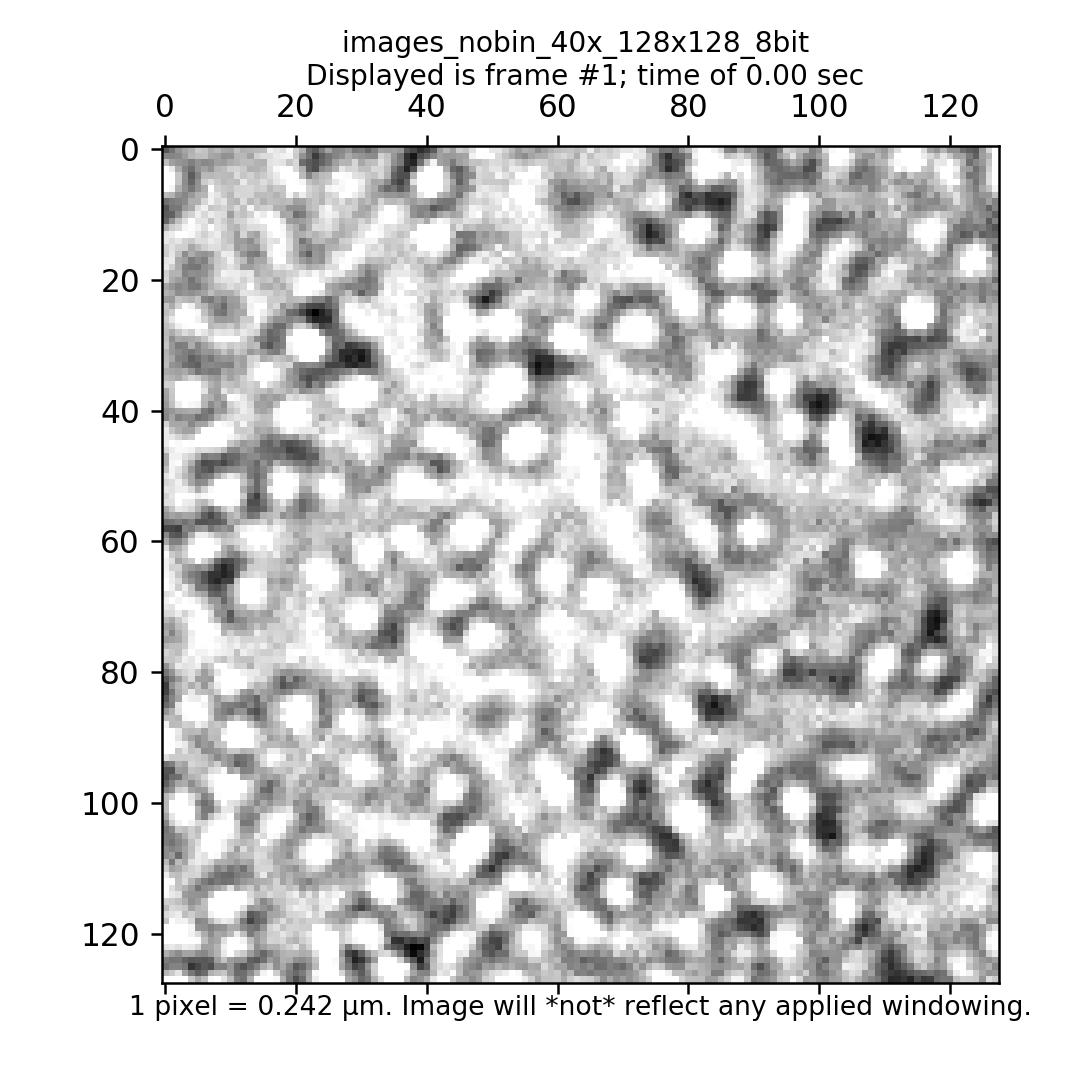

<IPython.core.display.Javascript object>


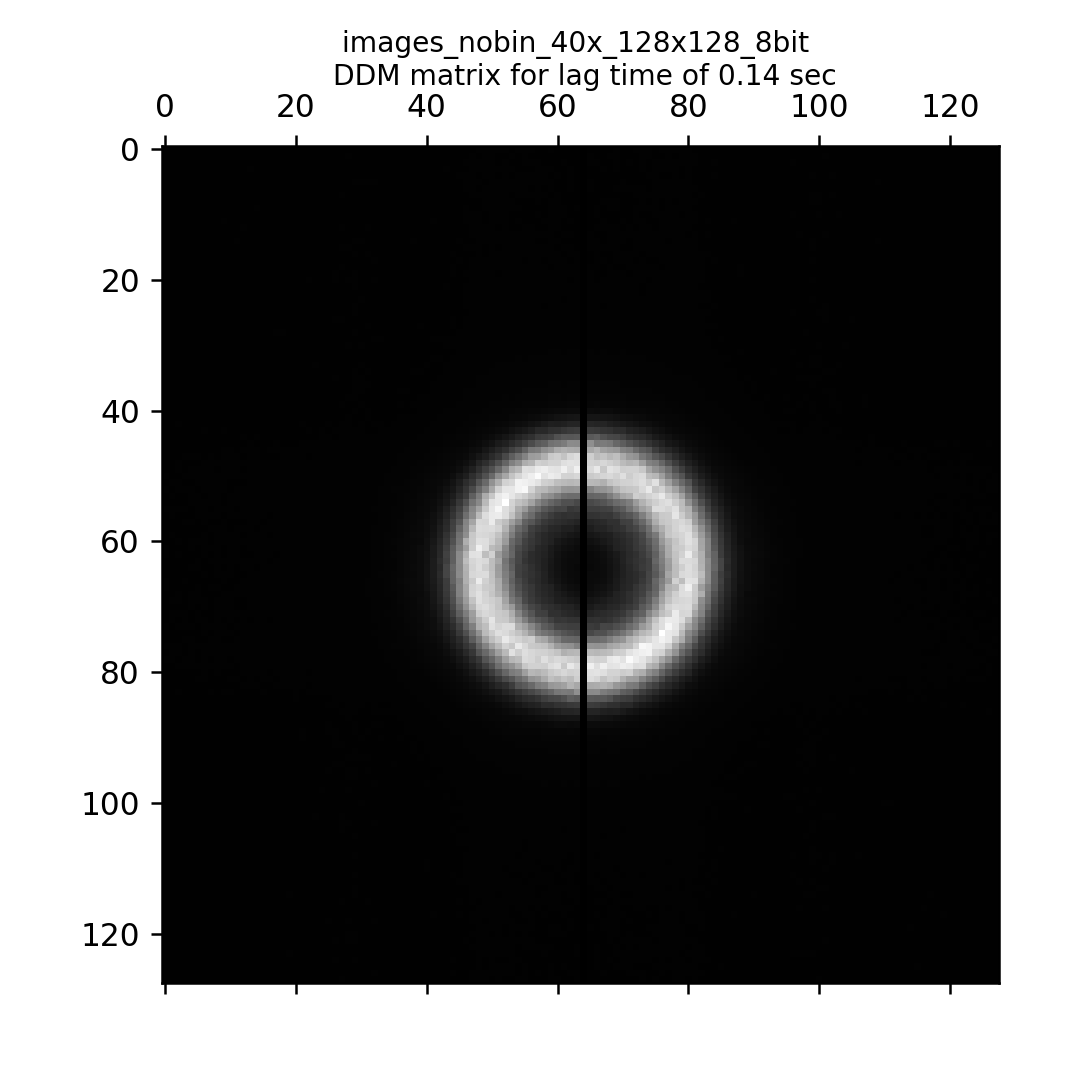

<IPython.core.display.Javascript object>


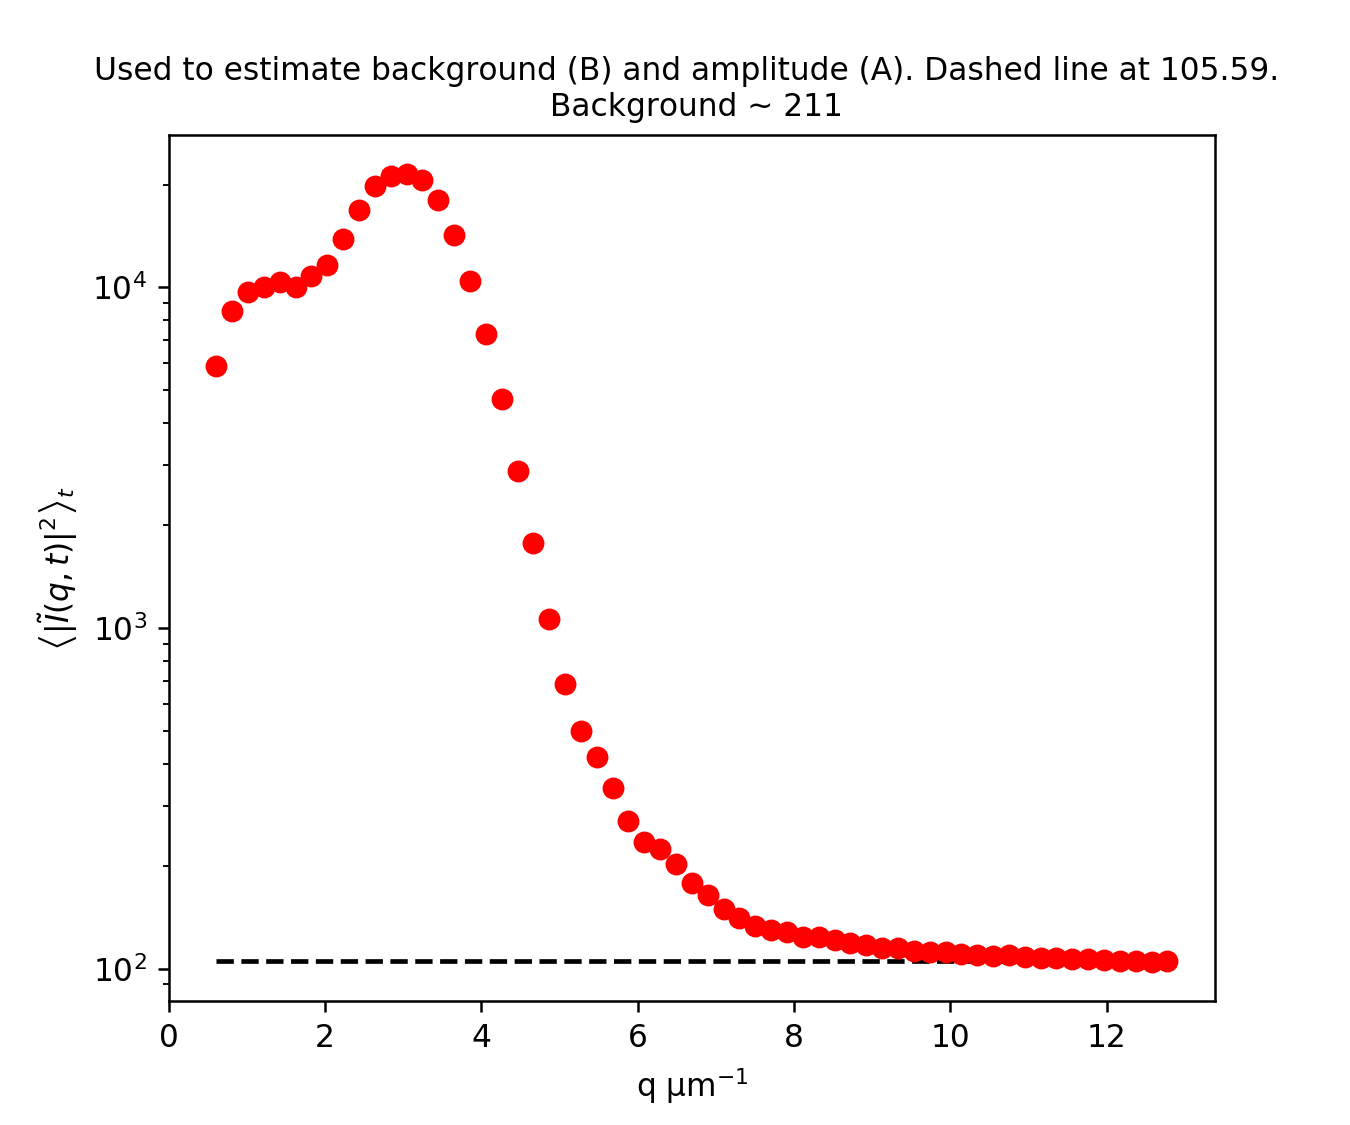

<IPython.core.display.Javascript object>


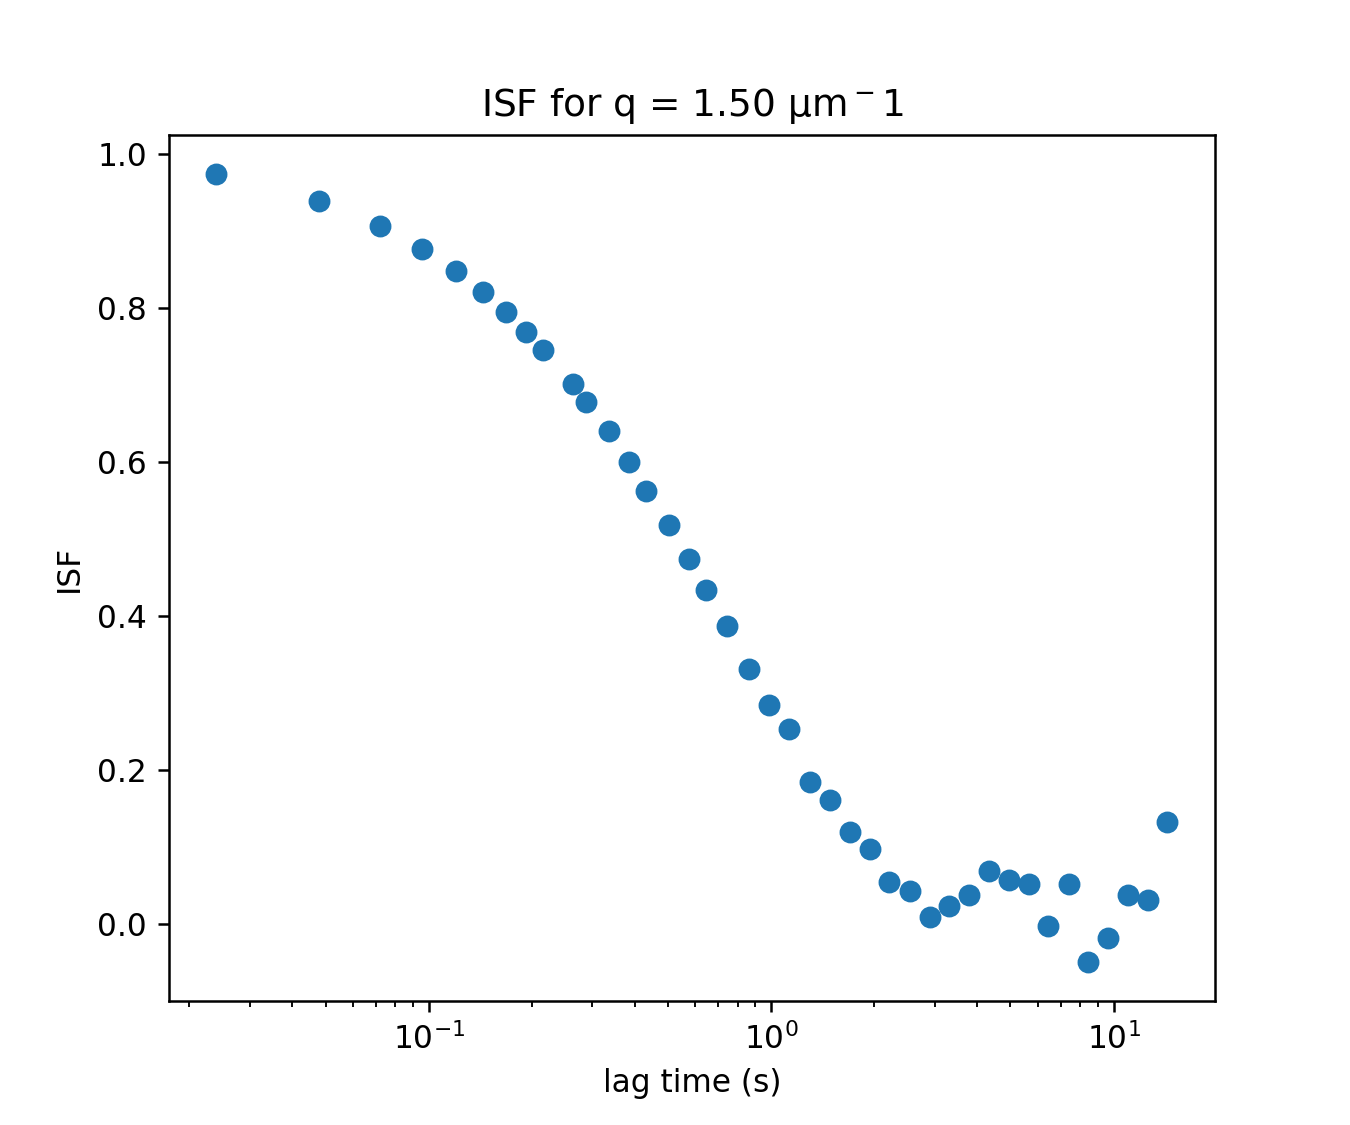

In [42]:
ddm_calc.calculate_DDM_matrix(quiet=True)

### 5.1 DDM dataset and report

In [43]:
display(ddm_calc.ddm_dataset)

<xarray.Dataset>
Dimensions:           (frames: 40, lagtime: 40, q: 64, q_x: 128, q_y: 128, x: 128, y: 128)
Coordinates:
  * lagtime           (lagtime) float64 0.02398 0.04796 0.07194 ... 12.59 14.36
    framelag          (frames) int32 1 2 3 4 5 6 7 ... 308 352 402 459 525 599
  * q_y               (q_y) float64 -12.98 -12.78 -12.58 ... 12.37 12.58 12.78
  * q_x               (q_x) float64 -12.98 -12.78 -12.58 ... 12.37 12.58 12.78
  * q                 (q) float64 0.0 0.2028 0.4057 0.6085 ... 12.37 12.58 12.78
  * y                 (y) int32 0 1 2 3 4 5 6 7 ... 121 122 123 124 125 126 127
  * x                 (x) int32 0 1 2 3 4 5 6 7 ... 121 122 123 124 125 126 127
Dimensions without coordinates: frames
Data variables:
    ddm_matrix_full   (lagtime, q_y, q_x) float64 194.5 183.5 ... 192.0 196.8
    ddm_matrix        (lagtime, q) float64 0.0 294.2 321.4 ... 207.8 201.1 200.4
    first_image       (y, x) float64 128.0 149.0 173.0 ... 175.0 229.0 215.0
    avg_image_ft      (q) float64 0.0 1.293e+05 5.225e+03 ... 105.3 104.7 105.3
    num_pairs_per_dt  (lagtime) int32 2999 2998 2997 1498 1498 ... 20 17 15 13
    B                 float64 211.2
    B_std             float64 1.491
    Amplitude         (q) float64 -211.2 2.585e+05 1.024e+04 ... -1.699 -0.52
    ISF               (lagtime, q) float64 0.0 0.9997 0.9892 ... -4.952 -19.73
Attributes:
    units:             Intensity
    lagtime:           sec
    q:                 μm$^{-1}$
    x:                 pixels
    y:                 pixels
    info:              ddm_matrix is the averages of FFT difference images, r...
    BackgroundMethod:  0
    OverlapMethod:     2
    DataDirectory:     ./
    FileName:          images_nobin_40x_128x128_8bit.tif
    pixel_size:        0.242
    frame_rate:        41.7
    number_lag_times:  40
    last_lag_time:     600

### 5.2 Amplitude and background parameters

In [44]:
print("Estimated background: %.1f" % ddm_calc.ddm_dataset.B)

Estimated background: 211.2


### 5.3 Intermediate scattering function (ISF)

## 6. Fitting the DDM matrix or ISF

## Initiazing DDM_Fit class and fitting our data to a model
Next, we initialize the `DDM_Fit` class which will help us fit the calculated DDM matrix to a model of our choosing. 

When the `DDM_Fit` fit class is initialized, it will display a table of the parameters, with the initial guesses and bounds, that were in the parameters of the yaml file. It will also indicate if, for the chosen model, initial guesses for parameters are missing. 

In [7]:
ddm_fit = ddm.DDM_Fit(ddm_calc.data_yaml)

,Initial guess,Minimum,Maximum
Amplitude,100.0,1.000,1000000.0
Tau,1.0,0.001,10.0
Background,25000.0,0.000,10000000.0
StretchingExp,1.0,0.500,1.1


Loading file C:/Users/rmcgorty/Documents/GitHub/PyDDM/Examples/images_nobin_40x_128x128_8bit_ddmmatrix.nc ...


Below, the fit is performed and saved into an xarray Dataset. We also have a table of the parameters for each q. Since this table may be long (especially if you have a large image size), you might want to not display it. If that's the case, then run this command with the `display_table` parmeter set to False, i.e.:
```python
fit01 = ddm_fit.fit(name_fit = 'fit01', display_table=False)
```

In [8]:
fit01 = ddm_fit.fit(name_fit = 'fit01')

In function 'get_tau_vs_q_fit', using new tau...
Fit is saved in fittings dictionary with key 'fit01'.


,q,Amplitude,Tau,Background,StretchingExp
0,0.000000,1.000000,10.000000,0.000000,1.100000
1,0.202840,5009.160959,10.000000,125.265537,0.500000
2,0.405681,8482.808495,10.000000,0.000000,0.525256
3,0.608521,10442.590957,3.868067,110.613248,0.710762
4,0.811362,16595.852548,2.556070,83.269636,0.811578
5,1.014202,18774.162108,1.424364,101.316228,0.909133
6,1.217043,20126.206549,1.035536,37.943122,0.911751
7,1.419883,20269.935277,0.742219,30.165661,0.952913
8,1.622723,19408.933976,0.552100,0.000000,0.955882
9,1.825564,21442.103307,0.465083,0.000000,0.977973


We can now take a look at the best fit parameters determined by the fitting code. We can generate a set of plots and have the output saved as PDF with the function `fit_report`. This takes a few arguments, including:
* the result of the fit in an xarray Dataset (here `fit01`)
* `q_indices`: the DDM matrix or the ISF (whichever was used in the fitting) will be plotted at these $q$-values specified by their index in the array of $q$-values
* `forced_qs`: range of $q$-values (specified, again, by the index) for which to extract power law relationship between the decay time $\tau$ and $q$

In function 'get_tau_vs_q_fit', using new tau...
In hf.plot_one_tau_vs_q function, using new tau... 


<xarray.Dataset>
Dimensions:          (parameter: 4, q: 64, lagtime: 40)
Coordinates:
  * parameter        (parameter) <U13 'Amplitude' 'Tau' ... 'StretchingExp'
  * q                (q) float64 0.0 0.2028 0.4057 0.6085 ... 12.37 12.58 12.78
  * lagtime          (lagtime) float64 0.02398 0.04796 0.07194 ... 12.59 14.36
Data variables:
    parameters       (parameter, q) float64 1.0 5.009e+03 ... 0.9077 0.9903
    theory           (lagtime, q) float64 0.001311 364.7 349.3 ... 206.3 206.3
    isf_data         (lagtime, q) float64 ...
    ddm_matrix_data  (lagtime, q) float64 ...
    A                (q) float64 -211.2 2.585e+05 1.024e+04 ... -1.699 -0.52
    B                float64 211.2
Attributes: (12/16)
    model:                          DDM Matrix - Single Exponential
    data_to_use:                    DDM Matrix
    initial_params_dict:            ["{'n': 0, 'value': 100.0, 'limits': [1.0...
    effective_diffusion_coeff:      0.616760567419975
    tau_vs_q_slope:                 [-1.9799845]
    msd_alpha:                      [1.01010892]
    ...                             ...
    velocity_std:                   0.4160131054430251
    good_q_range:                   [4, 16]
    DataDirectory:                  C:/Users/rmcgorty/Documents/GitHub/PyDDM/...
    FileName:                       images_nobin_40x_128x128_8bit.tif
    pixel_size:                     0.242
    frame_rate:                     41.7

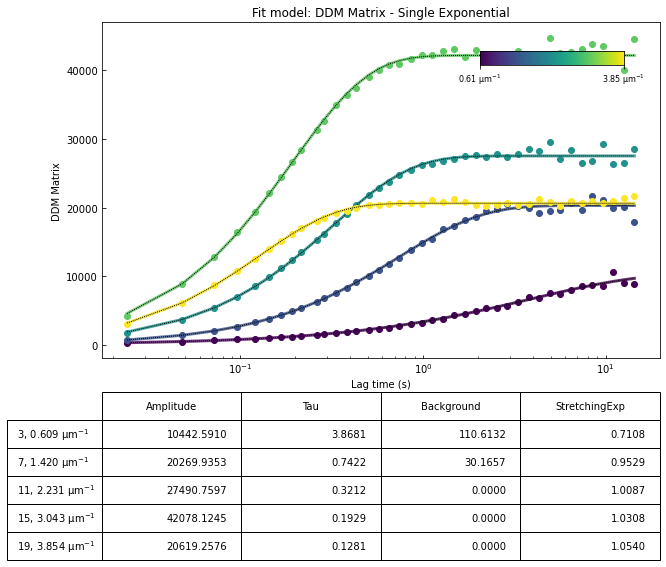

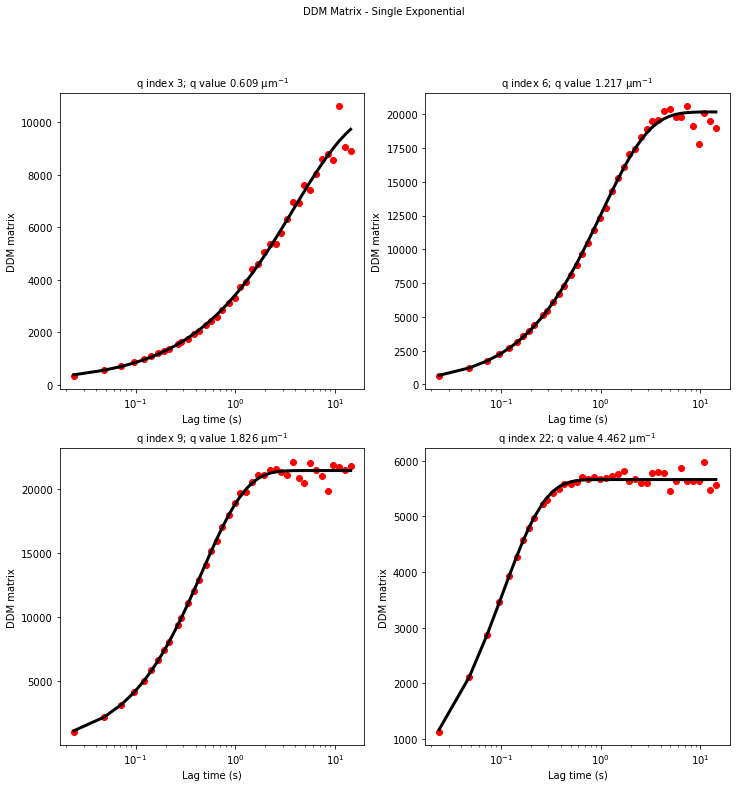

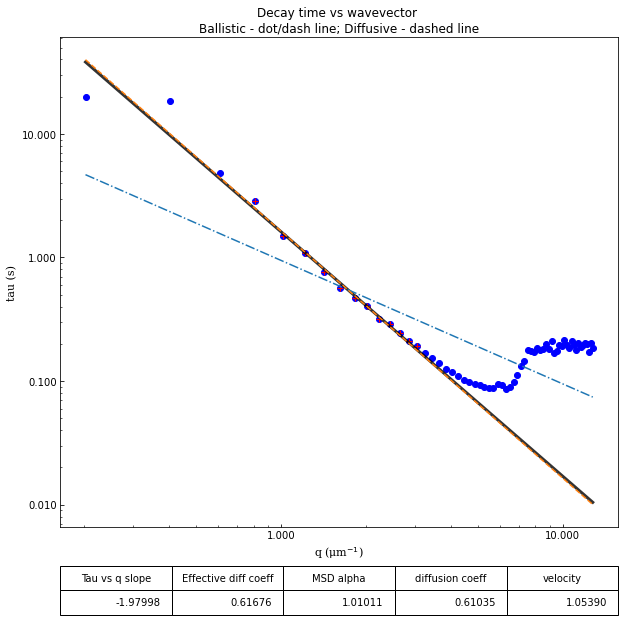

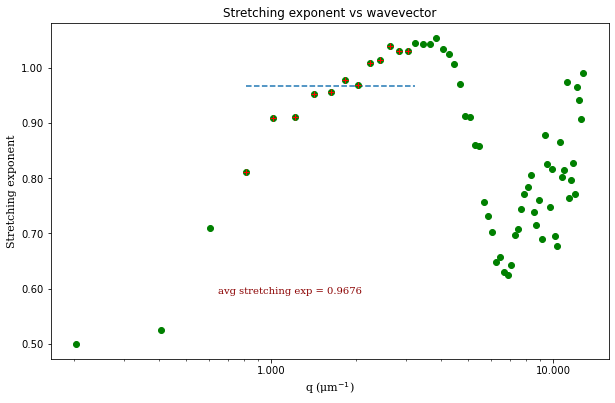

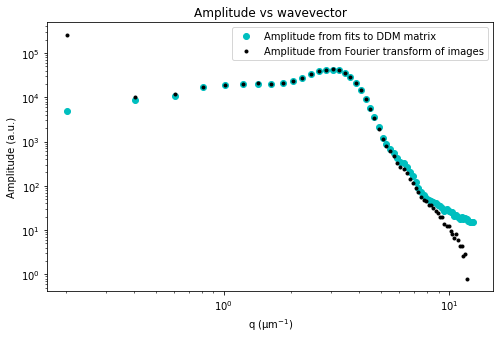

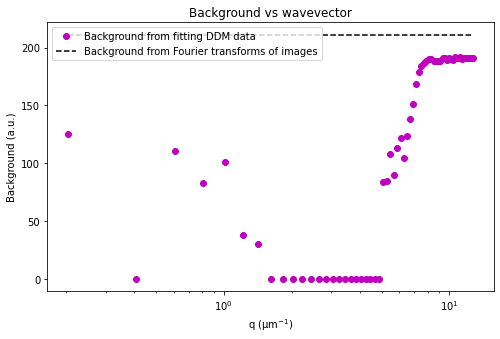

In [9]:
ddm.fit_report(fit01, q_indices=[3,6,9,22], forced_qs=[4,16], use_new_tau=True, show=True)

### Trying a different mathematical model
Above, we fit the DDM matrix to a model where the intermediate scattering function (ISF or $f(q,\Delta t)$) is an exponential. That is, we fit our data to:
$$ D(q,\Delta t) = A(q) \left[ 1 - \exp \left(-\Delta t / \tau(q) \right) ^{s(q)} \right] + B(q)$$
where $A$ is the amplitude, $B$ is the background, $\tau$ is the decay time, and $s$ is the stretching exponent. 

An alternative is to use other information to determine $A(q)$ and $B$ and then fit only the ISF. We will try this below.

In [9]:
ddm_fit.reload_fit_model_by_name("ISF - Single Exponential")

,Initial guess,Minimum,Maximum
Tau,1.0,0.001,10.0
StretchingExp,1.0,0.500,1.1


In [10]:
fit02 = ddm_fit.fit(name_fit = 'fit02', display_table=False)

In function 'get_tau_vs_q_fit', using new tau...
Fit is saved in fittings dictionary with key 'fit02'.


In function 'get_tau_vs_q_fit', using new tau...
In hf.plot_one_tau_vs_q function, using new tau... 


<xarray.Dataset>
Dimensions:          (parameter: 2, q: 64, lagtime: 40)
Coordinates:
  * parameter        (parameter) <U13 'Tau' 'StretchingExp'
  * q                (q) float64 0.0 0.2028 0.4057 0.6085 ... 12.37 12.58 12.78
  * lagtime          (lagtime) float64 0.02398 0.04796 0.07194 ... 12.59 14.36
Data variables:
    parameters       (parameter, q) float64 0.001886 10.0 10.0 ... 1.1 1.093
    theory           (lagtime, q) float64 4.761e-07 0.9987 0.9812 ... 0.0 0.0
    isf_data         (lagtime, q) float64 ...
    ddm_matrix_data  (lagtime, q) float64 ...
    A                (q) float64 -211.2 2.585e+05 1.024e+04 ... -1.699 -0.52
    B                float64 211.2
Attributes: (12/16)
    model:                          ISF - Single Exponential
    data_to_use:                    ISF
    initial_params_dict:            ["{'n': 0, 'value': 1.0, 'limits': [0.001...
    effective_diffusion_coeff:      0.6044361168424172
    tau_vs_q_slope:                 [-1.97401294]
    msd_alpha:                      [1.01316459]
    ...                             ...
    velocity_std:                   0.4159865239946986
    good_q_range:                   [4, 16]
    DataDirectory:                  C:/Users/rmcgorty/Documents/GitHub/PyDDM/...
    FileName:                       images_nobin_40x_128x128_8bit.tif
    pixel_size:                     0.242
    frame_rate:                     41.7

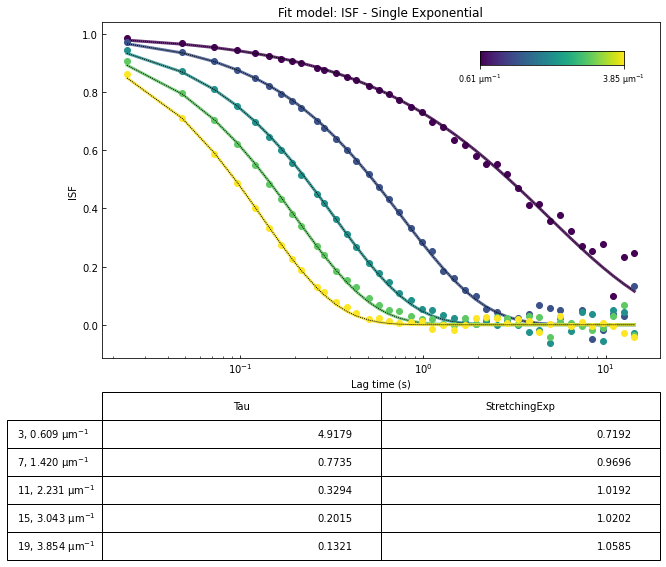

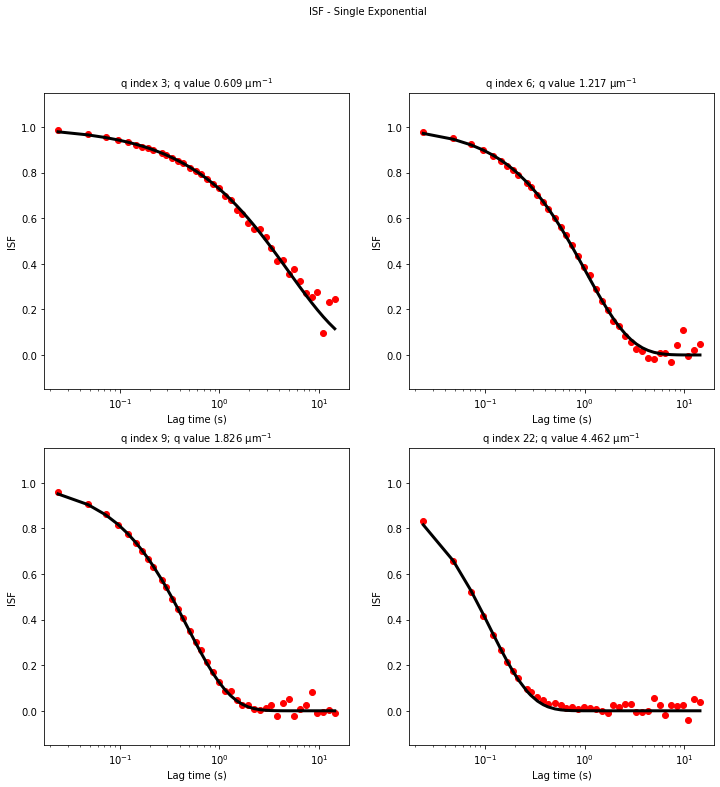

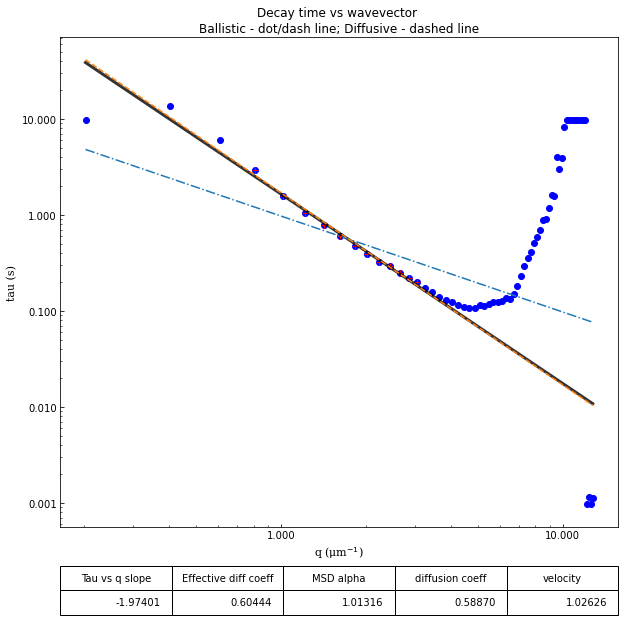

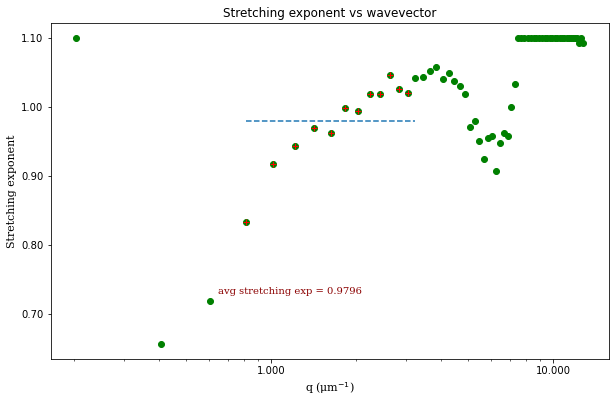

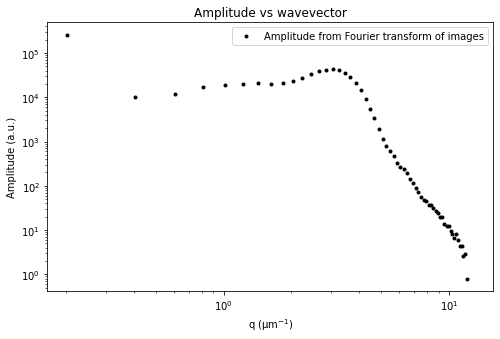

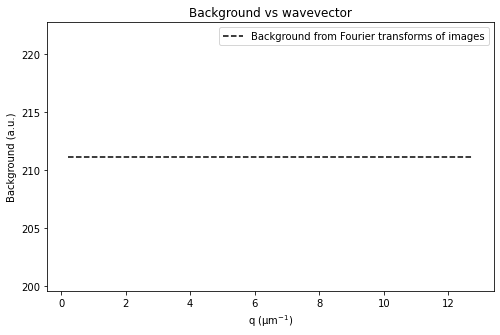

In [11]:
ddm.fit_report(fit02, q_indices=[3,6,9,22], forced_qs=[4,16], use_new_tau=True, show=True)

In [ ]:
plt.figure()
plt.semilogx(ddm_fit.ddm_dataset.lagtime, ddm_fit.ddm_dataset.ddm_matrix[:,-1],'ro')
plt.title("Looking at highest q (typically, quickest to decay)")
plt.xlabel("Lag time (s)")
plt.ylabel("DDM Matrix")

In [ ]:
ddm_fit.ddm_dataset = ddm.recalculate_ISF_with_new_background(ddm_fit.ddm_dataset, 10)

In [ ]:
fit02 = ddm_fit.fit(name_fit = 'fit02', display_table=False)

In [ ]:
ddm.fit_report(fit02, q_indices=[3,6,9,22], forced_qs=[4,16], use_new_tau=True, show=True)

## Interactive with matplotlib

Using the `Browse_DDM_Fits` class as shown below, one can interactively inspect the fits (to either the DDM matrix or the ISF) by selecting the appropriate point on the $\tau$ vs $q$ plot or by pressing 'N' or 'P' for next or previous. 

<IPython.core.display.Javascript object>


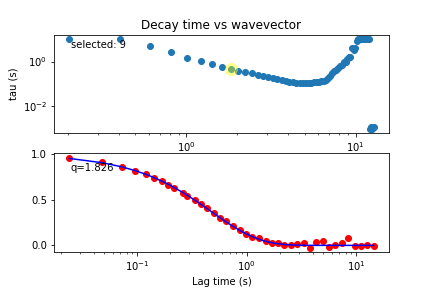

Click on a point in the tau vs q plot to see a fit.
Or press 'N' or 'P' to display next or previous fit.


Text(0, 0.5, 'tau (s)')

In [12]:
%matplotlib notebook
fig, (ax, ax2) = plt.subplots(2, 1)
browser = ddm.Browse_DDM_Fits(fig, ax, ax2, fit02)

fig.canvas.mpl_connect('pick_event', browser.on_pick)
fig.canvas.mpl_connect('key_press_event', browser.on_press)

ax.set_title('Decay time vs wavevector')
ax.set_xlabel("q")
ax.set_ylabel("tau (s)")

## Saving the results

In [ ]:
ddm.save_fit_results_to_excel(fit01)

In [ ]:
fit01.to_netcdf("example_netcdf_file.nc")

In [ ]:
loaded_netcdf_file = xr.open_dataset("example_netcdf_file.nc")